In [3]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import os
import random
# Torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
# Torchvison
import torchvision.transforms as T
import torchvision.models as modelszz

from torchvision.datasets import CIFAR100, CIFAR10
# Utils
import visdom
#from tqdm import tqdm
from tqdm.notebook import tqdm
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'
# Seed
random.seed("Chaeeun Ryu")
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
device =  torch.device('cuda:1')
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Hypothesis: Are the data selected for queries selected considering their performance per label?

In [4]:
#get acc
def test(models, dataloaders, mode = "train", device = device, MARGIN = 1):
    MARGIN = MARGIN
    assert mode == "train" or mode == "test"
    models['backbone'].eval()
    models['module'].eval()
    
    total = 0
    correct = 0
    criterion = nn.CrossEntropyLoss(reduction='none')
    epoch_backbone_loss = 0.
    epoch_m_module_loss = 0.
    epoch_total_loss = 0.
    test_iter = len(dataloaders[mode])
    with torch.no_grad():
        for (inputs, labels) in dataloaders[mode]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            scores, features = models['backbone'](inputs)
            _, preds = torch.max(scores.data,1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            ##### get predicted loss
            if mode == "test" or mode == "val":
                target_loss = criterion(scores, labels)
                pred_loss = models['module'](features)
                pred_loss = pred_loss.view(pred_loss.size(0))
                m_backbone_loss = torch.sum(target_loss) / target_loss.size(0)
                m_module_loss   = LossPredLoss(pred_loss, target_loss, margin=MARGIN)
                loss  = m_backbone_loss + WEIGHT * m_module_loss
                epoch_backbone_loss += m_backbone_loss.item()
                epoch_m_module_loss += m_module_loss.item()
                epoch_total_loss += loss.item()
    final_backbone_loss = epoch_backbone_loss/test_iter
    final_m_module_loss = epoch_m_module_loss/test_iter
    final_loss = epoch_total_loss/test_iter
    if mode == "train":
        return 100 * correct / total
    else:
        return 100 * correct / total, final_backbone_loss, final_m_module_loss, final_loss

In [5]:
class SubsetSequentialSampler(torch.utils.data.Sampler):
    r"""Samples elements sequentially from a given list of indices, without replacement.
    Arguments:
        indices (sequence): a sequence of indices
    """
    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))
    
    def __len__(self):
        return len(self.indices)

In [6]:
def get_uncertainty(models, unlabeled_loader, criterion = None, device = device):
    models['backbone'].eval()
    models['module'].eval()
    uncertainty = torch.tensor([]).to(device)
    
    with torch.no_grad():
        for (inputs, labels) in unlabeled_loader:
            inputs = inputs.to(device)
            
            scores, features = models['backbone'](inputs)
            pred_loss = models['module'](features)
            pred_loss = pred_loss.view(pred_loss.size(0))
            #labels = labels.to(device)
            #gt_loss = criterion(scores, labels)
            #print("predicted loss:",pred_loss)
            #print("ground truth loss:",gt_loss)
            uncertainty = torch.cat((uncertainty, pred_loss),0)#make it as a list
    return uncertainty.cpu()

# Models

In [7]:
'''ResNet in PyTorch.
Reference:
https://github.com/kuangliu/pytorch-cifar
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out1 = self.layer1(out)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)
        out = F.avg_pool2d(out4, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out, [out1, out2, out3, out4]


def ResNet18(num_classes = 10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes)

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])

# Original Loss Net

In [10]:
class LossNet(nn.Module):
    def __init__(self, feature_sizes=[32, 16, 8, 4], num_channels=[64, 128, 256, 512], interm_dim=128):
        super(LossNet, self).__init__()
        
        self.GAP1 = nn.AvgPool2d(feature_sizes[0])
        self.GAP2 = nn.AvgPool2d(feature_sizes[1])
        self.GAP3 = nn.AvgPool2d(feature_sizes[2])
        self.GAP4 = nn.AvgPool2d(feature_sizes[3])

        self.FC1 = nn.Linear(num_channels[0], interm_dim)
        self.FC2 = nn.Linear(num_channels[1], interm_dim)
        self.FC3 = nn.Linear(num_channels[2], interm_dim)
        self.FC4 = nn.Linear(num_channels[3], interm_dim)

        self.linear = nn.Linear(4 * interm_dim, 1)
    
    def forward(self, features):
        out1 = self.GAP1(features[0])
        out1 = out1.view(out1.size(0), -1)
        out1 = F.relu(self.FC1(out1))

        out2 = self.GAP2(features[1])
        out2 = out2.view(out2.size(0), -1)
        out2 = F.relu(self.FC2(out2))

        out3 = self.GAP3(features[2])
        out3 = out3.view(out3.size(0), -1)
        out3 = F.relu(self.FC3(out3))

        out4 = self.GAP4(features[3])
        out4 = out4.view(out4.size(0), -1)
        out4 = F.relu(self.FC4(out4))

        out = self.linear(torch.cat((out1, out2, out3, out4), 1))
        return out

# Data

In [11]:
train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomCrop(size=32, padding=4),
    T.ToTensor(),
    T.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]) # T.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)) # CIFAR-100
])

test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]) # T.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)) # CIFAR-100
])

cifar10_train = CIFAR10('../cifar10', train=True, download=True, transform=train_transform)
cifar10_unlabeled   = CIFAR10('../cifar10', train=True, download=True, transform=test_transform)
cifar10_test  = CIFAR10('../cifar10', train=False, download=True, transform=test_transform)
len_train_labeled = len(cifar10_train)
len_train_unlabeled = len(cifar10_unlabeled)
len_test = len(cifar10_test)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# LossPredLoss

In [12]:
def LossPredLoss(input, target, margin=1.0, reduction='mean'):
    assert len(input) % 2 == 0, 'the batch size is not even.'
    assert len(pred_loss) == len(target_loss)
    assert input.shape == input.flip(0).shape
    #print(f"original batch size: {len(input)}"): 8
    input = (input - input.flip(0))[:len(input)//2] # [l_1 - l_2B, l_2 - l_2B-1, ... , l_B - l_B+1], where batch_size = 2B
    target = (target - target.flip(0))[:len(target)//2]
    target = target.detach()
    #print(f"new size: {len(input)}"): 4
    one = 2 * torch.sign(torch.clamp(target, min=0)) - 1 # 1 operation which is defined by the authors
    
    if reduction == 'mean':
        loss = torch.sum(torch.clamp(margin - one * input, min=0))
        loss = loss / input.size(0) # Note that the size of input is already halved
    elif reduction == 'none':
        loss = torch.clamp(margin - one * input, min=0)
    else:
        NotImplementedError()
    
    return loss

# Config

In [13]:
TRIALS = 3
NUM_TRAIN = len_train_labeled
ADDEDNUM  = 1000 # Added number
BATCH     = 128 # batchsize
LR = 0.1
MOMENTUM = 0.9
WDECAY = 5e-4
MILESTONES = [160]
MARGIN = 1.0 # xi
WEIGHT = 1.0
SUBSET = 10000#10000장씩 update
CYCLES = 10
TRIALS = 3

In [14]:
indices = list(range(NUM_TRAIN))
random.shuffle(indices)#shuffle indices in train data
labeled_set = indices[:ADDEDNUM]
unlabeled_set = indices[ADDEDNUM:]
train_loader = DataLoader(cifar10_train, batch_size=BATCH, 
                          sampler=SubsetRandomSampler(labeled_set),#index를 control함
                          pin_memory=True)
test_loader  = DataLoader(cifar10_test, batch_size=BATCH)
dataloaders  = {'train': train_loader, 'test': test_loader}

In [15]:
# Model
resnet18    = ResNet18(num_classes=10).to(device)
loss_module = LossNet().to(device)
models      = {'backbone': resnet18, 'module': loss_module}
torch.backends.cudnn.benchmark = False#입력 이미지 크기가 자주 변하지 않는다면, 초기 시간이 소요되지만 일반적으로 더 빠른 런타임의 효과를 볼 수 있다.

In [16]:
# Model
resnet18    = ResNet18(num_classes=10).to(device)
loss_module = LossNet().to(device)
models      = {'backbone': resnet18, 'module': loss_module}
torch.backends.cudnn.benchmark = False#입력 이미지 크기가 자주 변하지 않는다면, 초기 시간이 소요되지만 일반적으로 더 빠른 런타임의 효과를 볼 수 있다.
# Target Loss
criterion      = nn.CrossEntropyLoss(reduction='none')

# Optimizer
optim_backbone = optim.SGD(models['backbone'].parameters(), lr=LR, 
                        momentum=MOMENTUM, weight_decay=WDECAY)
optim_module   = optim.SGD(models['module'].parameters(), lr=LR, 
                        momentum=MOMENTUM, weight_decay=WDECAY)
#Scheduler
sched_backbone = lr_scheduler.MultiStepLR(optim_backbone, milestones=MILESTONES)
sched_module   = lr_scheduler.MultiStepLR(optim_module, milestones=MILESTONES)

optimizers = {'backbone': optim_backbone, 'module': optim_module}
schedulers = {'backbone': sched_backbone, 'module': sched_module}

# Data Prep & Data Loaders
indices = list(range(NUM_TRAIN))
random.shuffle(indices)#shuffle indices in train data
labeled_set = indices[:ADDEDNUM]
unlabeled_set = indices[ADDEDNUM:]
train_loader = DataLoader(cifar10_train, batch_size=BATCH, 
                          sampler=SubsetRandomSampler(labeled_set),#index를 control함
                          pin_memory=True)
test_loader  = DataLoader(cifar10_test, batch_size=BATCH)
dataloaders  = {'train': train_loader, 'test': test_loader}

In [18]:
from dataclasses import dataclass
@dataclass
class BaselineConfig:
    TRIALS = 3
    NUM_TRAIN = len_train_labeled
    ADDEDNUM  = 1000 # Added number
    BATCH     = 128 # batchsize
    LR = 0.1
    MOMENTUM = 0.9
    WDECAY = 5e-4
    MILESTONES = [160]
    MARGIN = 1.0 # xi
    WEIGHT = 1.0
    SUBSET = 10000#1000장씩 update
    CYCLES = 10
    TRIALS = 3
config = BaselineConfig()

# Load model weights

In [21]:
baseline_ckpt = torch.load('EXACTbaseline_checkpoint.pt')
models['backbone'].load_state_dict(baseline_ckpt['model_backbone'])
models['module'].load_state_dict(baseline_ckpt['model_module'])

<All keys matched successfully>

# Check test acc per label

In [28]:
total_labels = {}
correct_labels = {}

for i in range(10):
    total_labels[str(i)] = 0
    correct_labels[str(i)] = 0

models['backbone'].eval()
models['module'].eval()

total = 0
correct = 0
criterion = nn.CrossEntropyLoss(reduction='none')
epoch_backbone_loss = 0.
epoch_m_module_loss = 0.
epoch_total_loss = 0.
test_iter = len(dataloaders['test'])
with torch.no_grad():
    for (inputs, labels) in tqdm(dataloaders['test'],desc = "running test loader.."):
        inputs = inputs.to(device)
        labels = labels.to(device)

        scores, features = models['backbone'](inputs)
        _, preds = torch.max(scores.data,1)
        for l, p in zip(list(labels.cpu().detach().numpy()),list(preds.cpu().detach().numpy())):
            if l == p:
                correct_labels[str(l)] +=1
            total_labels[str(l)] += 1
        total += labels.size(0)
        correct += (preds == labels).sum().item()

running test loader..:   0%|          | 0/79 [00:00<?, ?it/s]

In [31]:
print(f"total test accuracy:{100 * correct / total}")

total test accuracy:89.15


In [39]:
print("===========Accuracy per label============")
acc_dict = {}
for _ in range(10):
    print(f"Label: {_} || {correct_labels[str(_)]/total_labels[str(_)]} ({correct_labels[str(_)]}/{total_labels[str(_)]})")
    acc_dict[str(_)] = correct_labels[str(_)]/total_labels[str(_)]

===========Accuracy per label============
Label: 0 || 0.893 (893/1000)
Label: 1 || 0.957 (957/1000)
Label: 2 || 0.845 (845/1000)
Label: 3 || 0.826 (826/1000)
Label: 4 || 0.9 (900/1000)
Label: 5 || 0.833 (833/1000)
Label: 6 || 0.917 (917/1000)
Label: 7 || 0.889 (889/1000)
Label: 8 || 0.931 (931/1000)
Label: 9 || 0.924 (924/1000)


In [45]:
acc_dict.values()

dict_values([0.893, 0.957, 0.845, 0.826, 0.9, 0.833, 0.917, 0.889, 0.931, 0.924])

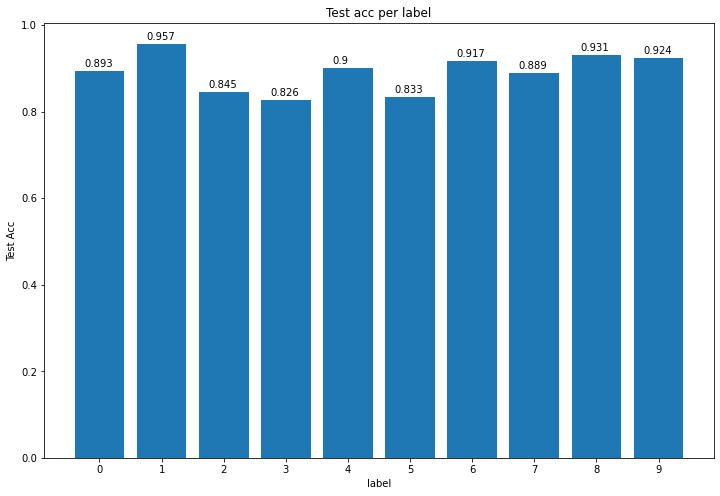

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,8))
plt.bar(acc_dict.keys(), acc_dict.values())
xlocs, xlabs = plt.xticks()
for i, v in enumerate(acc_dict.values()):
    plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
plt.title("Test acc per label")
plt.xlabel("label")
plt.ylabel("Test Acc")
plt.show()

In [50]:
random.shuffle(unlabeled_set)
subset = unlabeled_set[:SUBSET]#update 1000 more indices from unlabeled dataset -> get 1000 more data
unlabeled_loader = DataLoader(cifar10_unlabeled, batch_size = BATCH,
                              #Samples elements sequentially from a given list of indices, without replacement.
                             sampler = SubsetSequentialSampler(subset),
                             pin_memory = True)

uncertainty = get_uncertainty(models, unlabeled_loader)#measure uncertainty
# Index in ascending order of uncertainty
arg = np.argsort(uncertainty)

In [52]:
selected_subset = list(torch.tensor(subset)[arg][-ADDEDNUM:].numpy())

In [57]:
len(selected_subset)

1000

In [53]:
dataloaders['train'] = DataLoader(cifar10_train, batch_size = BATCH,
                                     sampler = SubsetRandomSampler(selected_subset),
                                     pin_memory = True)

In [60]:
selected_labels = []
for img, label in dataloaders['train']:
    selected_labels += list(label.cpu().detach().numpy())

In [64]:
from collections import Counter
sorted_counter = sorted(Counter(selected_labels).items())

In [86]:
sorted_counter

[(0, 81),
 (1, 62),
 (2, 114),
 (3, 111),
 (4, 123),
 (5, 74),
 (6, 110),
 (7, 159),
 (8, 82),
 (9, 84)]

In [80]:
keys_ =[]
vals_ = []
for s in sorted_counter:
    keys_.append(s[0])
    vals_.append(s[1]/500)

In [81]:
sum(vals_)

1.9999999999999998

In [82]:
sum(acc_dict.values())

8.915000000000001

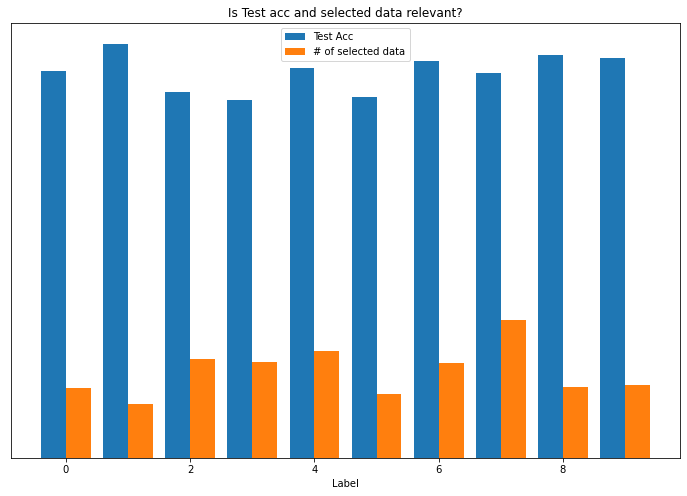

In [85]:
x_axis = np.arange(10)
plt.figure(figsize = (12,8))
# Multi bar Chart
plt.title("Is Test acc and selected data relevant?")
plt.bar(x_axis -0.2, acc_dict.values(), width=0.4, label = 'Test Acc')
plt.bar(x_axis +0.2, vals_, width=0.4, label = '# of selected data')
plt.xlabel("Label")
plt.yticks([])
plt.legend()

In [89]:
from scipy import stats
correlation, p_value = stats.pearsonr(list(acc_dict.values()), vals_)
print(correlation)

-0.2878261251246377


In [90]:
list(acc_dict.values())

[0.893, 0.957, 0.845, 0.826, 0.9, 0.833, 0.917, 0.889, 0.931, 0.924]

In [91]:
acc_dict

{'0': 0.893,
 '1': 0.957,
 '2': 0.845,
 '3': 0.826,
 '4': 0.9,
 '5': 0.833,
 '6': 0.917,
 '7': 0.889,
 '8': 0.931,
 '9': 0.924}